# Can we identify party affiliations from voting records?

Using the voting record for the Massachusetts house of representatives for the last two years as a base, unstructured learning (kmeans) was applied to a dataset that had only bill names and voting record.  The results were interesting in that there is really very little independent decision making on the part of individual reps and the correlation to party positions is quite high.  

The results are somewhat predictable in that two main groups emerge, and when checked against declared party affiliations, Democrats and Republicans are both grouped tightly and easily identifiable.  Most interesting is that the two declared "independents" in the House are effectively democrats in terms of voting, and the most "independent" when votes are cast are really democratic reps.

As an aside, most of the difficulty with this analysis was in the data cleaning stage.  The voting records are only available as PDF files, and the processing of those files is not straight forward.  Multiple packages were tested, and a combination of pdfminer, PyPDF2, and tabula-py was the most effective at scanning the voting tables.

In [1]:
# Basic imports, set dataframe with to accomodate large number of reps and bills

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
from scipy import stats

import io

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

#import io

#from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
#from pdfminer.converter import TextConverter
#from pdfminer.layout import LAParams
#from pdfminer.pdfpage import PDFPage

import PyPDF2
#from PyPDF2 import PdfFileReader
import tabula

pd.set_option('display.max_columns', None)

## PDF Processing:
Examine full PDF file, count total votes, and break file into individual files for ease of conversion with tabula.  It is also necessary to process the vote columns themselves.  Bills have a varying number of positive, negative, abstensions, and late votes.  From an data perspective, the challenge is that the bills don't scan in a uniform fashion and need to be cleaned.

Additionally, tabula was unable to scan page 61 and a special action (labeled band-aid) was required to process that page.

Finally, individual rep votes are processed into a useful dataframe.

In [2]:
#  Need this for processing page header, bill descriptions, and limited summary information on votes
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    
    retstr =io.BytesIO()
    
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,
                                  password=password,
                                  caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

In [3]:
# Set filename variables
filename="combined2018_RollCalls.pdf"
path="C://Users//bill_//OneDrive//Reps_Data//"
full_name=path+filename
problem_pages=[]

# Scan number of total votes
my_obj=open(full_name,'rb')
reader=PyPDF2.PdfFileReader(my_obj)
pg_count=reader.numPages
print 'Found {} pages.'.format(pg_count)

# Read pdf into DataFrame.  Total PDF has been split into individul votes, 1 pdf per vote

all_votes_df=pd.DataFrame()

for pg in range(1,pg_count):

    fname="document-page"+str(pg)+".pdf"
    full_name=path+fname #laod appropriate vote

    df2 = tabula.read_pdf(full_name,pandas_options ={'header': None},pages='all')
    df2.fillna('',inplace=True)
    
    yea_col=[]
    nay_col=[]
    absent_col=[]
    name_col=[]

    #  Set up column identification and vote type counts
    for c in df2.columns:
        entries=list(df2[c].unique())
        if 'Y' in entries:
            yea_col.append(c)
        elif 'N' in entries:
            nay_col.append(c)
        elif 'X' in entries:
            absent_col.append(c)
        elif 'P' in entries:
            absent_col.append(c)
        else:
            name_col.append(c)

    # Determine column content
    yea_col=sorted(list(set(yea_col)))
    nay_col=sorted(list(set(nay_col)))
    absent_col=sorted(list(set(absent_col)))
    name_columns=sorted(list(set(df2.columns).difference(set(yea_col+nay_col+absent_col))))

    # Page 61 bandaid
    if pg in [61,186,187,188,189]:
        
        # bandaid to fix names

        first_name_col=int(name_columns[0])

        def get_name(thing):
            '''Accept a thing that is made up of a name, possibly an asterisk, and possibly a vote.  Return only the name.'''
            tmp=thing.replace(' *','').split(' ')
            tmp=[x for x in tmp if x!= 'Y']
            return ' '.join(tmp)

        names=map(get_name,df2[first_name_col].values)
        
        #  Need to process out 'Y' from names and replace appropriately.  Take advantage of fact that
        #  no rep name ends in upper case y

        bob=df2[first_name_col].apply(lambda x: x.split(' '))
        yes_bandaid=[x[-1] if x[-1]=='Y' else '' for x in bob ]

        df2[first_name_col]=names
        df2.insert(first_name_col+1, 'bandaid', yes_bandaid)
        df2.columns=range(len(df2.columns))

    new_df=pd.DataFrame()
    start=0

    # Process Vote columns.  See picture for example of supplield PDF format, but essentially multiple columns of vote
    # type for each rep, with typically 4 columns of rep.  Process each column of reps and associated votes, rep names
    # added as a column.  
    
    for i in range(len(name_columns)):
        tmp_df=df2.loc[:,(df2.columns>=start)&(df2.columns<=name_columns[i])]
        tmp_cols=tmp_df.columns
        tmp_df['vote']=''

        for v in range(start,name_columns[i]):
            tmp_df['vote']=tmp_df['vote']+tmp_df[v]

        tmp_df['name']=df2[v+1]
        tmp_df.drop(tmp_cols,inplace=True,axis=1)
        start=name_columns[i]+1
        new_df=new_df.append(tmp_df,ignore_index=True)
        
    page_num=pg
    bob=convert_pdf_to_txt(full_name)
    bob=[x for x in bob.split('\n') if x != '']

    # Make debugging easier by pre-labling columns
    default=str(page_num)+'_Problem'
    bill_num=default
    vote_nm=default
    yeas=default
    no_vote=default
    vote_date=default
    vote_time=default

    #if pg in [66,71,72,103,151,209]:
     #   print 40*'#','\n',pg
        
    flag=0 
    f_yeas=0
    f_nays=0
    f_no_vote=0
    f_date=0
    f_num=0
    f_name=0
    
    
    for i in range(len(bob)):    #range(20):
        if 'YEAS' in bob[i]:
            yeas=int(bob[i].split(' ')[0])
            f_yeas=1
            
        if 'NAYS' in bob[i]:
            nays=int(bob[i].split(' ')[0])
            f_nays=1
            
        if 'N/V' in bob[i]:
            no_vote=int(bob[i].split(' ')[0])
            f_no_vote=1
            
        if '/201' in bob[i]:
            vote_date=bob[i].split(' ')[0]
            vote_time=bob[i].split(' ')[1]+' '+bob[i].split(' ')[2]
            f_date=1

        if 'No. ' in bob[i]:
            bill_num=int(bob[i].split(' ')[1])
            f_num=1
            
        if ('H.' in bob[i]) or ('S.' in bob[i]) or ('QUORUM' in bob[i]) or ('On suspension' in bob[i])\
            or ('Shall decision of the Chair stand' in bob[i]):
            vote_nm=bob[i]
            f_name=1
        
        flag=f_yeas+f_nays+f_no_vote+f_date+f_num+f_name
        if flag==6:
            break
        
    flag=0
            
    new_df['bill_num']=bill_num
    new_df['vote_nm']=vote_nm
    new_df['no_vote']=no_vote
    new_df['yeas']=yeas
    new_df['nays']=nays
    new_df['vote_date']=vote_date
    new_df['vote_time']=vote_time
    new_df['page_num']=pg
    all_votes_df=all_votes_df.append(new_df,ignore_index=True)

    def check_vote_types(thing):
        votes=[x for x in thing if (x!='N') and (x!='Y') and (x!='X') and (x!='P') and (x!='')]
        vote=sorted(list(votes))
                         
        if vote==[]:
            return ''
        
        problem_pages.append(pg)
        #print 'Issues with vote on page: {}'.format(pg)
        return 
    
    check_vote_types(new_df.vote)

all_votes_df.to_csv("reps_record_1_6_19.csv",encoding='utf-8',index=False)

print "Had problems on {} pages.  There were {} pages that were read correctly or {:3.0f}% success rate"\
    .format(len(problem_pages),pg_count-len(problem_pages),(1-float(len(problem_pages))/pg_count)*100)
print "Problem pages were: "
for p in problem_pages:
    print p,' ',
all_votes_df.tail(3)

Found 215 pages.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:84]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:87]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:89]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Had problems on 9 pages.  There were 206 pages that were read correctly or  96% success rate
Problem pages were: 
2   3   4   61   85   186   187   188   189  

,vote,name,bill_num,vote_nm,no_vote,yeas,nays,vote_date,vote_time,page_num
32646,Y,Wong,521,H. 4757 On Enactment Land Taking,3,150,0,08/01/2018,01:12 AM,214
32647,Y,Goldstein-Rose,521,H. 4757 On Enactment Land Taking,3,150,0,08/01/2018,01:12 AM,214
32648,Y,Whipps,521,H. 4757 On Enactment Land Taking,3,150,0,08/01/2018,01:12 AM,214


In [97]:
# remove problem_pages, convert Y votes to 1 and everything else to 0 (somewhat simplified, but basically, 
# the rep supports the bill or you doesn't.  Voting present, or late equals no) look at raw data
proper_df=all_votes_df.loc[(all_votes_df.page_num.isin(problem_pages)==False),:]
sorted(list(proper_df.vote.unique()))
proper_df['vote_val']=proper_df.vote.apply(lambda x: 1 if x=='Y' else (-1 if x=='N' else 0))
print proper_df.vote_val.mean()
proper_df.head(3)

0.735952899014


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:5]


,vote,name,bill_num,vote_nm,no_vote,yeas,nays,vote_date,vote_time,page_num,vote_val
0,Y,Mr. Speaker,307,H. 4134 On Engrossment,8,150,1,01/24/2018,05:37 PM,1,1
1,Y,Mariano,307,H. 4134 On Engrossment,8,150,1,01/24/2018,05:37 PM,1,1
2,Y,Haddad,307,H. 4134 On Engrossment,8,150,1,01/24/2018,05:37 PM,1,1


In [93]:
sorted(proper_df.name.unique())

['',
 u'Arciero',
 u'Arciero *',
 u'Ashe',
 u'Ashe *',
 u'Atkins',
 u'Atkins *',
 u'Ayers',
 u'Balser',
 u'Balser *',
 u'Barber',
 u'Barrett',
 u'Barrett *',
 u'Barrows',
 u'Benson',
 u'Berthiaume',
 u'Berthiaume *',
 u'Boldyga',
 u'Boldyga *',
 u'Brodeur',
 u'Brodeur *',
 u'Cabral',
 u'Cabral *',
 u'Cahill',
 u'Cahill *',
 u'Calter',
 u'Campanale',
 u'Campanale *',
 u'Campbell',
 u'Campbell *',
 u'Cantwell',
 u'Cantwell *',
 u'Carvalho',
 u'Carvalho *',
 u'Cassidy',
 u'Chan',
 u'Collins',
 u'Collins *',
 u'Connolly',
 u'Coppinger',
 u'Coppinger *',
 u'Crighton',
 u'Crocker',
 u'Cronin',
 u'Cullinane',
 u'Cusack',
 u'Cusack *',
 u'Cutler',
 u"D'Emilia",
 u'Day',
 u'Day *',
 u'DeCoste',
 u'DeCoste *',
 u'Decker',
 u'Decker *',
 u'DiZoglio',
 u'DiZoglio *',
 u'Diehl',
 u'Diehl *',
 u'Donahue',
 u'Donato',
 u'Dooley',
 u'Dooley *',
 u'Driscoll',
 u'DuBois',
 u'DuBois *',
 u'Durant',
 u'Dwyer',
 u'Dykema',
 u'Dykema *',
 u'Ehrlich',
 u'Ehrlich *',
 u'Farley-Bouvier',
 u'Farley-Bouvier *',


In [98]:
# Make a df to look at vote counts per bill
#tmp=proper_df.loc[(all_votes_df.page_num.isin([2,3,4,61,85])==0),:]
tmp2=proper_df.pivot_table(index='vote_nm',columns=['vote'],values='page_num',aggfunc='count')
tmp2.fillna(0,inplace=True)
tmp2.transpose()
tmp2.sum()

vote
         5.0
N     3765.0
P        4.0
X      713.0
Y    26765.0
dtype: float64

In [99]:
#rep_col_df=all_votes_df.loc[(all_votes_df.page_num.isin([2,3,4,61,85])==False),:].rename(columns={'name':'rep_name'}).copy()
rep_col_df=proper_df.rename(columns={'name':'rep_name'}).copy()
rep_col_df['rep_name']=rep_col_df.apply(lambda x: x.rep_name.encode('ascii','ignore').replace(' *',''),axis=1)
rep_col_df=rep_col_df.pivot_table(index='rep_name',columns='vote_nm',values='vote_val',aggfunc='max')
rep_col_df.fillna(0,inplace=True)
rep_col_df.head()

vote_nm,"""Shall decision of the Chair stand?""",On suspension of House Rule 1A,QUORUM,H. 1102 On Enactment Land Taking,H. 1128 suspension of Rule 7A,H. 1390 Shall this bill stand over Gov objection,H. 2515 On Engrossment,H. 2515 On adoption of amendment #1,H. 3995 On Enactment Land Taking,H. 4001 On Engrossment,H. 4103 On Enactment Land Taking,H. 4134 On Engrossment,H. 4197 On Enactment Land Taking,H. 4232 On Engrossment,H. 4261 On Enactment Land taking,H. 4265 On Enactment Land Taking,H. 4268 On Enactment Land taking,H. 4291 On Amendment 2,H. 4291 On adoption of the order,H. 4291 on adoption of consolidated amendment A,H. 4301 On Enactment Land Taking,H. 4312 On Enactment Land taking,H. 4314 On Engrossment,H. 4366 On Engrossment,H. 4367 On Engrossment,H. 4373 On Enactment,H. 4399 On adoption of the Order,"H. 4400 Consolidated ""A"" Education & Local Aid","H. 4400 Consolidated ""B"" Energy & Environ. Affairs","H. 4400 Consolidated ""C"" Veterans & Social Service","H. 4400 Consolidated ""D"" H.H.S. and Elder Affairs","H. 4400 Consolidated ""E"" Public Safety & Judiciay","H. 4400 Consolidated ""F"" Housing, M.H.& D.S.","H. 4400 Consolidated ""G"" Public Health","H. 4400 Consolidated ""H"" Const Of, St Admin, Trans","H. 4400 Consolidated ""I"" Labor and Economic Dev.",H. 4400 On Amendment 1248,H. 4400 On Amendment 227,H. 4400 On Amendment 31,H. 4400 On Amendment 347,H. 4400 On Amendment 773,H. 4400 On Amendment 908,H. 4400 On Engrossment,H. 4449 On Enactment State Loan,H. 4449 on acceptance of the Report,H. 4479 On Engrossment,H. 4486 On adoption of the further amendment,H. 4501 On Engrossment,H. 4516 On Enactment,H. 4516 On Engrossment,H. 4517 On Engrossment,H. 4517 On adoption of amendment #12,H. 4517 On adoption of amendment #3,H. 4517 On adoption of amendment #33,H. 4517 On adoption of amendment #35,H. 4517 On adoption of amendment #41,H. 4517 On adoption of amendment #6,H. 4536 On Enactment State Loan,H. 4536 On acceptance of the conference report,H. 4546 On Engrossment,H. 4549 On Enactment State Loan,H. 4549 On acceptance of the conference report,H. 4561 On Enactment Land taking,H. 4599 On Engrossment,H. 4599 On adoption of consolidated amendment A,H. 4606 On adoption,"H. 4617 ""Shall decision of the Chair stand?""",H. 4617 On Engrossment,H. 4617 On adoption of amendment #1,H. 4627 On Enactment Land Taking,H. 4633 On Enactment Land Taking,H. 4634 On Enactment Land taking,H. 4636 On Enactment Land Taking,H. 4640 On Enactment,H. 4640 On Engrossment,H. 4640 On Ordering to a third reading,H. 4640 On adoption of amendment #3,H. 4664 On Engrossment,H. 4664 On adoption of amendment #1,H. 4665 On Engrossment,H. 4667 On Engrossment,H. 4667 On adoption of amendment #12,H. 4670 On Enactment,H. 4670 On acceptance of the conference report,H. 4688 On Enactment Land Taking,H. 4689 On Enactment Land Taking,H. 4714 On Engrossment,H. 4714 On adoption of consolidated amendment A,H. 4717 On Enactment Land Taking,H. 4725 On Engrossment,H. 4725 On further Amendment,H. 4730 On Engrossment,H. 4732 On Enactment state loan,H. 4737 On Engrossment,H. 4738 On Engrossment,H. 4738 On adoption of amendment 28,H. 4739 On Engrossment,H. 4742 On Enactment,H. 4749 On Engrossment,H. 4757 On Enactment Land Taking,H. 4760 On Enactment Land Taking,H. 4800 Item # 0339-1011 Re-Entry Programs,H. 4800 Item # 1595-6368 CTF/Transportation Fund,H. 4800 Item # 2000-0100 EOEEA Administration,H. 4800 Item # 2800-0700 Office of Dam Safety,H. 4800 Item # 4000-0601 MassHealth Senior Care,H. 4800 Item # 7000-9501 Libraries Local Aid,H. 4800 Item # 7007-0801 Microlending,H. 4800 Item #0640-0300 MA. Cultural Council,H. 4800 Item #1450-1266 Academic Detailing,H. 4800 Item #1599-0026 Regionalization Grants,H. 4800 Item #1599-4417 Collins Center,H. 4800 Item #2330-0100 Div of Marin Fish Admin,H. 4800 Item #2511-0100 DAR Administration,H. 4800 Item #2800-0100 DCR Administration,H. 4800 Item #2800-0501 DCR Seasonals,"H. 4800 Item #2810-0122 State parks, Recreation",H. 4800 Item #400

In [104]:
# Apply simple unstructured learning to as a first step
# in identifying groups of reps

from sklearn.cluster import KMeans

# Initialize Model
n_clusters=2
model = KMeans(n_clusters=n_clusters)

# Fit Model
model.fit(rep_col_df)

# Prediction on the entire data
preds = model.predict(rep_col_df)
preds

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0])

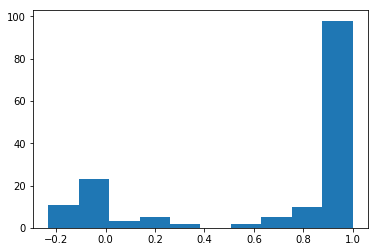

In [105]:
da_vote=rep_col_df.transpose()
corr=da_vote.corr()
corr.head(20)
plt.hist(corr['Mr. Speaker'].dropna(),bins=10)
plt.show()



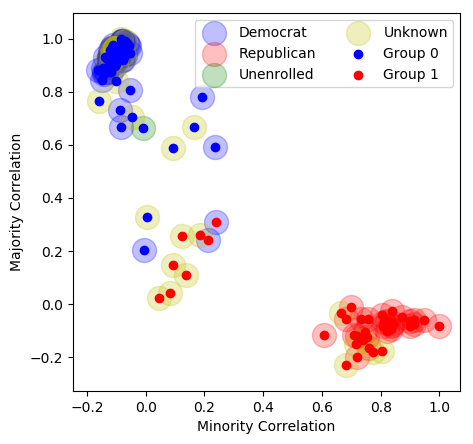

In [140]:
#print len(corr['Mr. Speaker']),len(rep_col_df.transpose().sum()),len(preds)
df_fin=pd.DataFrame(index=corr['Mr. Speaker'].index,columns=['Spkr_Corr','Min_Corr','For_sum','Preds'])
df_fin['Spkr_Corr']=corr['Mr. Speaker'].values
df_fin['Min_Corr']=corr['Jones'].values
df_fin['For_sum']=rep_col_df.transpose().sum().values
df_fin['Preds']=preds
df_fin['rep_name']=df_fin.index

def get_party(name):
    
    try:
        #print name,st_df.loc[st_df.Last_Name==name,'Party']
        return st_df.loc[st_df.Last_Name==name,'Party'].values[0]
    except:
        return 'Unknown'

df_fin['Party']=df_fin.rep_name.apply(get_party)


plt.figure(figsize=(5,5),dpi=100)

#Party Setup
party_colors=['b','r','g','y']
parties=sorted(list(df_fin.Party.unique()))
tar_sz=300

for c in range(len(parties)):
    tmp=df_fin.loc[df_fin.Party==parties[c],:]
    plt.scatter(tmp.Min_Corr,tmp.Spkr_Corr,color=party_colors[c],label='{}'.format(parties[c]),alpha=0.25,s=tar_sz)

cat_colors=['b','r','g']
for c in range(len(set(preds))):
    tmp=df_fin.loc[df_fin.Preds==c,:]
    plt.scatter(tmp.Min_Corr,tmp.Spkr_Corr,color=cat_colors[c],label='Group {}'.format(c))
plt.legend(loc='best',ncol=2)
plt.xlabel('Minority Correlation')
plt.ylabel('Majority Correlation')
plt.show()


In [73]:
class Ma_State_Rep_Data:
    
    def __init__(self):
        self.url='https://malegislature.gov/People/House'
        self.active_reps=self.get_active_reps()
        self.rep_list=self.get_rep_list()
        self.rep_dict=self.get_rep_dict()
        return
    
    def get_active_reps(self):
        '''Access current list of mass state reps.  Return dataframe containing:
        first and last names, voting district, county, party, office number and email address'''
        
        tmp=pd.read_html(self.url)
        df=tmp[0]
        df=df.loc[df[u'\n    First Name\n    \n    \n        \n        \n        \n    \n']!= 'Vacant',:]
        df.rename(columns={u'\n    First Name\n    \n    \n        \n        \n        \n    \n':'First_Name',
                       u'\n    Last Name\n    \n    \n        \n        \n        \n    \n':'Last_Name',
                       u'\n    Party\n    \n    \n        \n        \n        \n    \n':'Party'},
                     inplace=True)

        df.drop([u'Follow In My Legislature',u'Legislator Photo'],inplace=True,axis=1)
        df['County']=df.District.apply(lambda x: x.split(' ')[1])
        del tmp
        return df[['First_Name','Last_Name','District','County','Party','Room','Phone Number','Email Address']]

    def get_rep_list(self):
        return sorted(list(self.active_reps['Last_Name']))
    def get_rep_dict(self):

        tmp=self.active_reps[['First_Name','Last_Name','Party','District']].copy()
        tmp['Rep_Key']=tmp['Last_Name'].copy()
        
        tmp['Rep_Key']=tmp.apply((lambda x: x.Last_Name+','+x.First_Name[0]+'.' if
                                   ((x.Last_Name=='Hunt')|(x.Last_Name=='Rogers')|\
                                  (x.Last_Name=='Walsh')) else x.Last_Name),axis=1)
        
       
        tmp.index=tmp.Rep_Key
        tmp.drop('Rep_Key',axis=1,inplace=True)
        tmp=tmp.transpose()

        return tmp.to_dict()

    
### Initalize st_reps class   
st_reps=Ma_State_Rep_Data()
st_df=pd.DataFrame(st_reps.get_active_reps())

In [110]:
st_df=pd.DataFrame(st_reps.get_active_reps())
st_df.head(3)

,First_Name,Last_Name,District,County,Party,Room,Phone Number,Email Address
0,James,Arciero,2nd Middlesex,Middlesex,Democrat,172,617-722-2019,James.Arciero@mahouse.gov
1,Brian,Ashe,2nd Hampden,Hampden,Democrat,236,617-722-2430,Brian.Ashe@mahouse.gov
2,Bruce,Ayers,1st Norfolk,Norfolk,Democrat,167,617-722-2230,Bruce.Ayers@mahouse.gov


Index([   u'First_Name',     u'Last_Name',      u'District',        u'County',
               u'Party',          u'Room',  u'Phone Number', u'Email Address'],
      dtype='object')


In [88]:
print st_reps.get_rep_list()
tmp=proper_df.rename(columns={'name':'rep_name'}).copy()
tmp.rep_name=tmp.rep_name.apply(lambda x: x.replace(' *',''))
set(tmp.rep_name).difference(set(st_reps.rep_list))

[u'Arciero', u'Ashe', u'Ayers', u'Balser', u'Barber', u'Barrett', u'Barrows', u'Benson', u'Berthiaume', u'Biele', u'Blais', u'Boldyga', u'Brodeur', u'Cabral', u'Cahill', u'Campbell', u'Capano', u'Carey', u'Cassidy', u'Chan', u'Ciccolo', u'Connolly', u'Coppinger', u'Crocker', u'Cronin', u'Cullinane', u'Cusack', u'Cutler', u"D'Emilia", u'Day', u'DeCoste', u'DeLeo', u'Decker', u'Devers', u'Domb', u'Donahue', u'Donato', u'Dooley', u'Driscoll', u'DuBois', u'Durant', u'Dykema', u'Ehrlich', u'Elugardo', u'Farley-Bouvier', u'Ferguson', u'Fernandes', u'Ferrante', u'Finn', u'Fiola', u'Frost', u'Galvin', u'Garballey', u'Garlick', u'Garry', u'Gentile', u'Gifford', u'Golden', u'Gonz\xe1lez', u'Gordon', u'Gouveia', u'Gregoire', u'Haddad', u'Haggerty', u'Harrington', u'Hawkins', u'Hay', u'Hecht', u'Hendricks', u'Higgins', u'Hill', u'Hogan', u'Holmes', u'Honan', u'Howitt', u'Hunt', u'Hunt', u'Jones', u'Kafka', u'Kane', u'Kearney', u'Keefe', u'Kelcourse', u'Khan', u'LaNatra', u'Lawn', u'LeBoeuf', u'Lew

{'',
 u'Atkins',
 u'Calter',
 u'Campanale',
 u'Cantwell',
 u'Carvalho',
 u'Collins',
 u'Crighton',
 u'DiZoglio',
 u'Diehl',
 u'Dwyer',
 u'Goldstein-Rose',
 u'Gonzalez',
 u'Hunt, D.',
 u'Hunt, R.',
 u'Kaufman',
 u'Kocot',
 u'Koczera',
 u'Kulik',
 u'Kuros',
 u'Lyons',
 u'Matias',
 u'Miceli',
 u'Moran F.',
 u'Moran M.',
 u'Mr. Speaker',
 u'O\u2019Connell',
 u'O\u2019Day',
 u'Rogers, D.',
 u'Rogers, J.',
 u'Rushing',
 u'Scibak',
 u'Smizik',
 u'S\xe1nchez',
 u'Walsh, C.',
 u'Walsh, T.'}